In [1]:
import kagglehub
import os
# Download the latest version of the dataset
path = kagglehub.dataset_download("fedesoriano/company-bankruptcy-prediction")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\ADMIN\.cache\kagglehub\datasets\fedesoriano\company-bankruptcy-prediction\versions\2


In [2]:
# Identify the dataset file (usually a CSV file)
files = os.listdir(path)
print("Files in dataset folder:", files)


Files in dataset folder: ['data.csv']


In [5]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, brier_score_loss
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
import matplotlib.pyplot as plt
import requests

# Step 1: Load and Preprocess Data
# Load the dataset
# Assuming the dataset contains a CSV file, load it into a DataFrame
for file in files:
    if file.endswith(".csv"):
        dataset_path = os.path.join(path, file)
        df = pd.read_csv(dataset_path)
        print("Dataset loaded successfully into DataFrame!")
        break

# Display the first few rows of the dataset
print(df.head())
# Get column names
feature_names = df.columns



Dataset loaded successfully into DataFrame!
   Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3     

In [6]:
# Basic preprocessing
def preprocess_data(df):
    df.fillna(df.mean(), inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)
    return df

df = preprocess_data(df)
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

In [7]:
# Split features and target
X = df.drop(columns=['bankrupt?'])
y = df['bankrupt?']



In [8]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

In [9]:
# Step 1: Split Data into Training, Test, and Out-of-Sample (OOS) Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_test, X_oos, y_test, y_oos = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42)  # 0.3 * 0.33 = 0.1 for OOS

# Step 2: Stratified K-Fold Cross-Validation on Training Set
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = []
brier_scores = []

for train_index, test_index in skf.split(X_train, y_train):
    X_train_split, X_test_split = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_split, y_test_split = y_train.iloc[train_index], y_train.iloc[test_index]

    # Step 3: Train Initial XGBoost Model
    xgboost_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)
    xgboost_model.fit(X_train_split, y_train_split)

    # Step 4: Evaluate Model on Validation Set (within Cross-Validation)
    train_pred = xgboost_model.predict_proba(X_train_split)[:, 1]
    test_pred = xgboost_model.predict_proba(X_test_split)[:, 1]

    roc_auc_scores.append(roc_auc_score(y_test_split, test_pred))
    brier_scores.append(brier_score_loss(y_test_split, test_pred))

# Step 5: Output Cross-Validation Results (only mean values)
print(f"Mean ROC AUC: {np.mean(roc_auc_scores):.2f}")
print(f"Mean Brier Score: {np.mean(brier_scores):.2f}")


Mean ROC AUC: 0.94
Mean Brier Score: 0.02


In [15]:
# Step 6: Train Final Model on Entire Training Set (Post-Cross-Validation)
final_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)
final_model.fit(X_train, y_train)

# Step 7: Evaluate Final Model on Test and Out-of-Sample Sets
test_pred = final_model.predict_proba(X_test)[:, 1]

roc_auc_test = roc_auc_score(y_test, test_pred)
brier_test = brier_score_loss(y_test, test_pred)

# Step 8: Output Final Model Results
print(f"Test ROC AUC: {roc_auc_test:.2f}")
print(f"Test Brier Score: {brier_test:.2f}")

Test ROC AUC: 0.96
Test Brier Score: 0.02


In [16]:
# Step 6: Feature Engineering (Retain Top 20 Features)
importances = xgboost_model.get_booster().get_score(importance_type='gain')
importances_df = pd.DataFrame(list(importances.items()), columns=['Feature', 'Gain'])
importances_df = importances_df.sort_values(by='Gain', ascending=False)
top_features = importances_df['Feature'].head(20).tolist()

X_train_top = X_train[top_features]
top_features

["net_income_to_stockholder's_equity",
 'borrowing_dependency',
 'continuous_interest_rate_(after_tax)',
 'roa(c)_before_interest_and_depreciation_before_interest',
 'persistent_eps_in_the_last_four_seasons',
 'total_debt/total_net_worth',
 'interest-bearing_debt_interest_rate',
 'non-industry_income_and_expenditure/revenue',
 'operating_profit_per_person',
 'net_value_growth_rate',
 'net_profit_before_tax/paid-in_capital',
 'quick_ratio',
 'roa(b)_before_interest_and_depreciation_after_tax',
 'cash_flow_to_equity',
 'pre-tax_net_interest_rate',
 'debt_ratio_%',
 'operating_profit/paid-in_capital',
 'inventory/working_capital',
 'realized_sales_gross_profit_growth_rate',
 'roa(a)_before_interest_and_%_after_tax']

In [17]:
# Step 7: Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic', random_state=42),
                           param_grid=param_grid, cv=skf, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_train_top, y_train)

best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)



Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [20]:
# Step 8: Train Final Model on Full Training Set
best_model.fit(X_train_top, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [21]:
import joblib

# Save the trained model
joblib.dump(best_model, 'xgb_model.pkl')



['xgb_model.pkl']

In [22]:

# Save the scaler used for feature scaling
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [23]:
import pandas as pd

# Step 1: Ensure that X_oos_top contains the necessary features for prediction.
# Assuming the data is already preprocessed and ready for prediction.

# Step 2: Save the OOS data to CSV without performing any predictions
oos_results = X_oos.copy()  # Copy the OOS data
oos_results.to_csv('xgb_oos_data_for_prediction.csv', index=False)

# Check if the file was saved correctly
print("Out-of-Sample data saved to 'xgb_oos_data_for_prediction.csv'")


Out-of-Sample data saved to 'xgb_oos_data_for_prediction.csv'


In [29]:
import requests

# Step 11: Send Predictions to API
file_path = 'xgb_oos_data_for_prediction.csv'

with open(file_path, 'rb') as file:
    response = requests.post(
        'http://127.0.0.1:8000/convert_csv_to_json_and_predict/',
        files={'file': ('xgb_oos_predictions.csv', file, 'text/csv')}
    )

# Check the response status
if response.status_code == 200:
    print("200 Successful Response")
    predictions = response.json().get("data", [])
    
    # Write the first 20 predictions to a text file
    with open('predictions_output.txt', 'w') as f:
        for i, row in enumerate(predictions[:]):
            f.write(f"Prediction {i+1}: {row}\n")
    
    print("Predictions have been written to 'predictions_output.txt'.")
else:
    print("Error:", response.text)


200 Successful Response
Predictions have been written to 'predictions_output.txt'.


{"net_income_to_stockholder's_equity": 0.841213242933284, 'borrowing_dependency': 0.370076697168087, 'continuous_interest_rate_(after_tax)': 0.781815589148155, 'roa(c)_before_interest_and_depreciation_before_interest': 0.518744210988154, 'persistent_eps_in_the_last_four_seasons': 0.231256499952728, 'total_debt/total_net_worth': 0.0018065092696449, 'interest-bearing_debt_interest_rate': 0.0002350235023502, 'non-industry_income_and_expenditure/revenue': 0.303603803277389, 'operating_profit_per_person': 0.395129011103322, 'net_value_growth_rate': 0.0004600340347827, 'net_profit_before_tax/paid-in_capital': 0.18226378101199, 'quick_ratio': 0.0068179521314756, 'roa(b)_before_interest_and_depreciation_after_tax': 0.57021253814444, 'cash_flow_to_equity': 0.314310017237719, 'pre-tax_net_interest_rate': 0.797626298965089, 'debt_ratio_%': 0.0486440729207606, 'operating_profit/paid-in_capital': 0.106950347680232, 'inventory/working_capital': 0.277382314812481, 'realized_sales_gross_profit_growth_

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7612\182924007.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.fillna(df_selected.mean(), inplace=True)  # Fill missing values with column mean
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7612\182924007.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7612\182924007.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

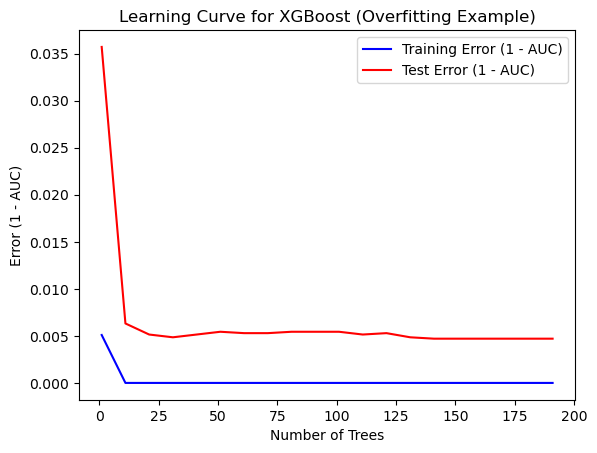

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score, brier_score_loss
from xgboost import XGBClassifier

# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a model on increasing numbers of trees to demonstrate overfitting
train_errors, test_errors = [], []

for n_estimators in range(1, 201, 10):
    model = XGBClassifier(objective='binary:logistic', n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict on training and test sets
    train_pred = model.predict_proba(X_train)[:, 1]
    test_pred = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC AUC and Brier score for training and test sets
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)
    
    # Store errors for plotting
    train_errors.append(1 - train_auc)  # Lower AUC is worse, so 1-AUC gives the error
    test_errors.append(1 - test_auc)

# Plot the learning curve
plt.plot(range(1, 201, 10), train_errors, label="Training Error (1 - AUC)", color='blue')
plt.plot(range(1, 201, 10), test_errors, label="Test Error (1 - AUC)", color='red')
plt.xlabel('Number of Trees')
plt.ylabel('Error (1 - AUC)')
plt.title('Learning Curve for XGBoost (Overfitting Example)')
plt.legend()
plt.show()
